Function: Used this notebook to find the dementia-cv risk quantiles where most of a potential trial population is. This will help us narrow the part of the dementia-cv quantile area that we use in trials. 

In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandarallel import pandarallel
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook
%matplotlib inline
%autosave 120

Autosaving every 120 seconds


In [3]:
from matplotlib import cm
#from mpl_toolkits.mplot3d import Axes3D
#ax = Axes3D(fig)

In [4]:
from microsim.bp_treatment_strategies import *

from microsim.outcome_model_repository import OutcomeModelRepository
from microsim.outcome_model_type import OutcomeModelType
from microsim.person import Person

from microsim.population import NHANESDirectSamplePopulation

from microsim.bp_treatment_strategies import SprintTreatment

from microsim.sim_settings import simSettings

from microsim.trials.trialset import TrialsetParallel, TrialsetSerial
from microsim.trials.trial_description import TrialDescription
from microsim.trials.logistic_regression_analysis import LogisticRegressionAnalysis
from microsim.trials.linear_regression_analysis import LinearRegressionAnalysis
from microsim.trials.outcome_assessor import OutcomeAssessor
from microsim.trials.attribute_outcome_assessor import AttributeOutcomeAssessor
from microsim.trials.attribute_outcome_assessor import AssessmentMethod
from microsim.trials.risk_filter import RiskFilter
from microsim.trials.trial_utils import get_analysis_name, randomizationSchema

from microsim.population import PersonListPopulation

from microsim.trials.bp_filter import BPFilter
from microsim.trials.bp_meds_filter import BPMedsFilter

In [5]:
#any microsim dir will work, just need to access the NHANES data
#microsimDir = "/users/PAS2164/deligkaris/MICROSIM/CODE/microsim"
microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)
imputedDataset = pd.read_stata(microsimDir + "/microsim/data/fullyImputedDataset.dta")
dataDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/NOTEBOOKS/DATA"

In [6]:
#if you want to see the years for which NHANES data exist
#imputedDataset.loc[imputedDataset["year"]==2017].head(10)

In [7]:
#at the beginning turn on pandarallel if you are planning to use TrialsetSerial
pandarallel.initialize(verbose=1) #microsim by default now does not initialize pandarallel
simSettings.pandarallelFlag = True #with this flag all new population instances will be set to use pandarallel

In [8]:
#to create the population I need some good quality random numbers
seedSequence = np.random.SeedSequence()
rngStream = np.random.default_rng(seed=seedSequence)

In [9]:
pop = NHANESDirectSamplePopulation(150000, 2017, rng=rngStream)

In [10]:
def select_trial_population(targetPopulation, inclusionFilters, exclusionFilters): #inclusionFilters: a list of filters
    filteredPeople = list(targetPopulation._people) #initialize
    for inclusionFilter in inclusionFilters:
        filteredPeople = list(filter(inclusionFilter, filteredPeople)) #applies logical AND to all inclusion filters provided
    return PersonListPopulation(filteredPeople)

In [11]:
sbpThreshold = 126
dbpThreshold = 85

In [12]:
myBPFilter = BPFilter({"_sbp": sbpThreshold, "_dbp": dbpThreshold })
myBPMedsFilter = BPMedsFilter({"_antiHypertensiveCount": 3})
myInclusionFilters = [myBPMedsFilter.doesNotExceedThresholds, 
                      myBPFilter.exceedsThresholds]

In [13]:
trialPop = select_trial_population(pop, myInclusionFilters, None)

In [14]:
#to see what percentage of the original population meets criteria for trial inclusion
#conclusion: only few people have dbp that is above the threshold, that seems to be the limiting factor
#15823 both, 16079 bp filter only (19305 above dbp threshold, 54799 above sbp threshold), 147699 bp meds filter only
len(list(trialPop._people))

15786

In [15]:
%%time
alive, df = trialPop.advance_vectorized(200, rng=rngStream)

CPU times: user 41min 21s, sys: 2min 13s, total: 43min 35s
Wall time: 50min 1s


In [ ]:
#%%time
#with pandarallel on these two steps are faster
#12min with 10,000, 22min with 20,000, 61min with 60,000, 102min with 100,000, 160min with 150,000
#osc: 27min with 10,000
#pop = NHANESDirectSamplePopulation(150000, 1999)
#alive, df = pop.advance_vectorized(200)

In [16]:
def getDFForPersonCol(person):
    df = pd.DataFrame(person.get_final_wave_state_as_dict())
    df['dfIndex'] = person.dfIndex
    df['cvRisk'] = df.apply(OutcomeModelRepository().get_risk_for_person, args=(OutcomeModelType.CARDIOVASCULAR, 1, True), axis='columns')
    df['demRisk'] = df.apply(OutcomeModelRepository().get_risk_for_person,  args=(OutcomeModelType.DEMENTIA, 1, True), axis='columns')
    return df

dfs = trialPop._people.apply(getDFForPersonCol)

In [17]:
allAgesDF = pd.concat(dfs.tolist())

In [18]:
#remove rows that represent the year the person died because the get_final_wave_state_as_dict function
#returns their age for that year to be -1 and that significantly distors their risks
allAgesDF = allAgesDF.loc[allAgesDF["alive"]==True]

In [ ]:
#allAgesDF.loc[allAgesDF.demRisk > 1, 'demRisk'].count(), allAgesDF.loc[allAgesDF.demRisk > 1, 'demRisk']

In [19]:
#if some points are outside of the min and max then qcut will return them to belong in NaN
allAgesDF.loc[allAgesDF.demRisk > 1, 'demRisk'] = 1

In [ ]:
#allAgesDF.demRisk.describe(), allAgesDF.cvRisk.describe()

In [20]:
allIndexAtBaselineDF = allAgesDF.loc[allAgesDF.groupby(['dfIndex'])["age"].idxmin()]

In [21]:
#df = allIndexAtBaselineDF #to get quantiles based on NHANES people
df = allIndexAtBaselineDF #to get quantiles based on person-years

In [22]:
nQuantiles = 10
increment = 1.0/nQuantiles
#qcut will move the left boundary to a value lower than the min, so that the left end (which is open)
#will include the min
#we need to have n+1 points in order to have n intervals

df['demRiskQuantile'] = pd.qcut(df.demRisk, np.arange(0, 1.0+increment, increment))
df['cvRiskQuantile'] = pd.qcut(df.cvRisk, np.arange(0, 1.0+increment, increment))

In [23]:
#there should not be any NaNs
(df['demRiskQuantile'].isna().sum(), df['cvRiskQuantile'].isna().sum(),
 df['demRiskQuantile'].isna().sum(), df['cvRiskQuantile'].isna().sum())

(0, 0, 0, 0)

In [24]:
meanDemRiskForQuantile = df.groupby('demRiskQuantile')['demRisk'].mean()
meanCVRiskForQuantile = df.groupby('cvRiskQuantile')['cvRisk'].mean()

meanDemRiskForQuantileDict = {index : value for index, value in meanDemRiskForQuantile.items()}
meanCVRiskForQuantileDict = {index : value for index, value in meanCVRiskForQuantile.items()}

demQuantileNumberForQuantile = {quantile : index for index, quantile 
                                in enumerate(df['demRiskQuantile'].value_counts(sort=False).index)}
cvQuantileNumberForQuantile = {quantile : index for index, quantile 
                               in enumerate(df['cvRiskQuantile'].value_counts(sort=False).index)}

demQuantileForNumber = {index : quantile for index, quantile 
                        in enumerate(df['demRiskQuantile'].value_counts(sort=False).index)}
cvQuantileForNumber = {index : quantile for index, quantile 
                       in enumerate(df['cvRiskQuantile'].value_counts(sort=False).index)}

In [25]:
df['meanDemRiskForQuantile'] = df['demRiskQuantile']
df['meanDemRiskForQuantile'].replace(meanDemRiskForQuantileDict, inplace=True)
df['meanCVRiskForQuantile'] = df['cvRiskQuantile']
df['meanCVRiskForQuantile'].replace(meanCVRiskForQuantileDict, inplace=True)

df['cvQuantileNum'] = df['cvRiskQuantile']
df['cvQuantileNum'].replace(cvQuantileNumberForQuantile, inplace=True)
df['demQuantileNum'] = df['demRiskQuantile']
df['demQuantileNum'].replace(demQuantileNumberForQuantile, inplace=True)

In [ ]:
### next step is to see how this varies by age...
### if we have wide distribution, then we can just go through deciles or something like that for trial sampling!

In [61]:
df["genderMale0Female1"] = df["gender"]-1

In [45]:
#with this approach we count the person-years and make quantiles based on these
countByRisks = df.groupby(
                            ['demQuantileNum', 'cvQuantileNum'],
                            sort=True
                            )['age'].count().unstack(fill_value=0).stack() #age is not important, just choose1column

countByRisksDF = pd.DataFrame(
                                {'demRisk' : countByRisks.index.get_level_values("demQuantileNum"),
                                 'cvRisk' : countByRisks.index.get_level_values("cvQuantileNum"),
                              'ageCount' : countByRisks.values})

meanAgeByRisks = df.groupby(
                            ['demQuantileNum', 'cvQuantileNum'],
                            sort=True
                            )['age'].mean().unstack(fill_value=0).stack() #age is not important, just choose1column

meanAgeByRisksDF = pd.DataFrame(
                                {'demRisk' : meanAgeByRisks.index.get_level_values("demQuantileNum"),
                                 'cvRisk' : meanAgeByRisks.index.get_level_values("cvQuantileNum"),
                              'meanAge' : meanAgeByRisks.values})

meanSbpByRisks = df.groupby(
                            ['demQuantileNum', 'cvQuantileNum'],
                            sort=True
                            )['sbp'].mean().unstack(fill_value=0).stack() #age is not important, just choose1column

meanSbpByRisksDF = pd.DataFrame(
                                {'demRisk' : meanSbpByRisks.index.get_level_values("demQuantileNum"),
                                 'cvRisk' : meanSbpByRisks.index.get_level_values("cvQuantileNum"),
                              'meanSbp' : meanSbpByRisks.values})

meanDbpByRisks = df.groupby(
                            ['demQuantileNum', 'cvQuantileNum'],
                            sort=True
                            )['dbp'].mean().unstack(fill_value=0).stack() #age is not important, just choose1column

meanDbpByRisksDF = pd.DataFrame(
                                {'demRisk' : meanDbpByRisks.index.get_level_values("demQuantileNum"),
                                 'cvRisk' : meanDbpByRisks.index.get_level_values("cvQuantileNum"),
                              'meanDbp' : meanDbpByRisks.values})

meanLdlByRisks = df.groupby(
                            ['demQuantileNum', 'cvQuantileNum'],
                            sort=True
                            )['ldl'].mean().unstack(fill_value=0).stack() #age is not important, just choose1column

meanLdlByRisksDF = pd.DataFrame(
                                {'demRisk' : meanLdlByRisks.index.get_level_values("demQuantileNum"),
                                 'cvRisk' : meanLdlByRisks.index.get_level_values("cvQuantileNum"),
                              'meanLdl' : meanLdlByRisks.values})

meanHdlByRisks = df.groupby(
                            ['demQuantileNum', 'cvQuantileNum'],
                            sort=True
                            )['hdl'].mean().unstack(fill_value=0).stack() #age is not important, just choose1column

meanHdlByRisksDF = pd.DataFrame(
                                {'demRisk' : meanHdlByRisks.index.get_level_values("demQuantileNum"),
                                 'cvRisk' : meanHdlByRisks.index.get_level_values("cvQuantileNum"),
                              'meanHdl' : meanHdlByRisks.values})

meanAntiHypertensiveCountByRisks = df.groupby(
                            ['demQuantileNum', 'cvQuantileNum'],
                            sort=True
                            )['antiHypertensiveCount'].mean().unstack(fill_value=0).stack() #age is not important, just choose1column

meanAntiHypertensiveCountByRisksDF = pd.DataFrame(
                                {'demRisk' : meanAntiHypertensiveCountByRisks.index.get_level_values("demQuantileNum"),
                                 'cvRisk' : meanAntiHypertensiveCountByRisks.index.get_level_values("cvQuantileNum"),
                              'meanAntiHypertensiveCount' : meanAntiHypertensiveCountByRisks.values})

femaleProportionByRisks = df.groupby(
                            ['demQuantileNum', 'cvQuantileNum'],
                            sort=True
                            )['genderMale0Female1'].mean().unstack(fill_value=0).stack() #age is not important, just choose1column

femaleProportionByRisksDF = pd.DataFrame(
                                {'demRisk' : femaleProportionByRisks.index.get_level_values("demQuantileNum"),
                                 'cvRisk' : femaleProportionByRisks.index.get_level_values("cvQuantileNum"),
                              'femaleProportion' : femaleProportionByRisks.values})

In [66]:
whiteCountByRisks = df[df["raceEthnicity"]==3].groupby(
                            ['demQuantileNum', 'cvQuantileNum'],
                            sort=True
                            )["raceEthnicity"].count().unstack(fill_value=0).stack() #age is not important, just choose1column

whiteCountByRisksDF = pd.DataFrame(
                                {'demRisk' : whiteCountByRisks.index.get_level_values("demQuantileNum"),
                                 'cvRisk' : whiteCountByRisks.index.get_level_values("cvQuantileNum"),
                              'whiteCount' : whiteCountByRisks.values})

In [ ]:
#with this approach we count NHANES indices and make quantiles based on these
#countIndexByRisks = allIndexAtBaselineDF.groupby(['demQuantileNum','cvQuantileNum'],sort=False
#                                )['dfIndex'].nunique().unstack(fill_value=0).stack()

#countIndexByRisksDF = pd.DataFrame({'demRisk' : countIndexByRisks.index.get_level_values("demQuantileNum"),
#                              'cvRisk' : countIndexByRisks.index.get_level_values("cvQuantileNum"),
#                              'indexCount' : countIndexByRisks.values})
#countIndexByRisksDF

In [27]:
#used in plots later
X=np.arange(0,nQuantiles,1)
Y=np.arange(0,nQuantiles,1)
X, Y = np.meshgrid(X, Y)
X.shape

(10, 10)

In [28]:
#this is done just in case the quantile categories are not ordered properly
countByRisksArray=np.zeros(X.shape)
for i,j,k in zip(countByRisksDF["demRisk"].values,
                 countByRisksDF["cvRisk"].values,
                 countByRisksDF["ageCount"].values):
    countByRisksArray[i,j]=k #i : demRisk, j: cvRisk
#countByRisksArray

In [63]:
meanAgeByRisksArray=np.zeros(X.shape)
for i,j,k in zip(meanAgeByRisksDF["demRisk"].values,
                 meanAgeByRisksDF["cvRisk"].values,
                 meanAgeByRisksDF["meanAge"].values):
    meanAgeByRisksArray[i,j]=k #i : demRisk, j: cvRisk

meanSbpByRisksArray=np.zeros(X.shape)
for i,j,k in zip(meanSbpByRisksDF["demRisk"].values,
                 meanSbpByRisksDF["cvRisk"].values,
                 meanSbpByRisksDF["meanSbp"].values):
    meanSbpByRisksArray[i,j]=k #i : demRisk, j: cvRisk
    
meanDbpByRisksArray=np.zeros(X.shape)
for i,j,k in zip(meanDbpByRisksDF["demRisk"].values,
                 meanDbpByRisksDF["cvRisk"].values,
                 meanDbpByRisksDF["meanDbp"].values):
    meanDbpByRisksArray[i,j]=k #i : demRisk, j: cvRisk

meanLdlByRisksArray=np.zeros(X.shape)
for i,j,k in zip(meanLdlByRisksDF["demRisk"].values,
                 meanLdlByRisksDF["cvRisk"].values,
                 meanLdlByRisksDF["meanLdl"].values):
    meanLdlByRisksArray[i,j]=k #i : demRisk, j: cvRisk
    
meanHdlByRisksArray=np.zeros(X.shape)
for i,j,k in zip(meanHdlByRisksDF["demRisk"].values,
                 meanHdlByRisksDF["cvRisk"].values,
                 meanHdlByRisksDF["meanHdl"].values):
    meanHdlByRisksArray[i,j]=k #i : demRisk, j: cvRisk
    
meanAntiHypertensiveCountByRisksArray=np.zeros(X.shape)
for i,j,k in zip(meanAntiHypertensiveCountByRisksDF["demRisk"].values,
                 meanAntiHypertensiveCountByRisksDF["cvRisk"].values,
                 meanAntiHypertensiveCountByRisksDF["meanAntiHypertensiveCount"].values):
    meanAntiHypertensiveCountByRisksArray[i,j]=k #i : demRisk, j: cvRisk
    
femaleProportionByRisksArray=np.zeros(X.shape)
for i,j,k in zip(femaleProportionByRisksDF["demRisk"].values,
                 femaleProportionByRisksDF["cvRisk"].values,
                 femaleProportionByRisksDF["femaleProportion"].values):
    femaleProportionByRisksArray[i,j]=k #i : demRisk, j: cvRisk

In [72]:
whiteCountByRisksArray=np.zeros(X.shape)
for i,j,k in zip(whiteCountByRisksDF["demRisk"].values,
                 whiteCountByRisksDF["cvRisk"].values,
                 whiteCountByRisksDF["whiteCount"].values):
    whiteCountByRisksArray[i,j]=k #i : demRisk, j: cvRisk
    
whiteProportionByRisksArray=np.zeros(X.shape)
for i,j,k in zip(whiteCountByRisksDF["demRisk"].values,
                 whiteCountByRisksDF["cvRisk"].values,
                 whiteCountByRisksDF["whiteCount"].values):
    if (countByRisksArray[i,j]!=0.):
        whiteProportionByRisksArray[i,j]=k/countByRisksArray[i,j] #i : demRisk, j: cvRisk
    else:
        whiteProportionByRisksArray[i,j]=0
        print(whiteProportionByRisksArray[i,j]) #should be 0 but show it anyway

0.0
0.0
0.0


In [ ]:
#this is done just in case the quantile categories are not ordered properly
#countIndexByRisksArray=np.zeros(X.shape)
#for i,j,k in zip(countIndexByRisksDF["demRisk"].values,
#                 countIndexByRisksDF["cvRisk"].values,
#                 countIndexByRisksDF["indexCount"].values):
#    countIndexByRisksArray[i,j]=k
#countByRisksArray

In [29]:
countSum = countByRisksDF["ageCount"].sum() #sum of all person-ages
countSumPerQbox = countSum/(nQuantiles)/(nQuantiles) # of person-ages in one qq category, uniform ditribution
countSum, countSumPerQbox

(10638572, 106385.72)

In [ ]:
#indexCountSum = countIndexByRisksDF["indexCount"].sum() #sum of all person-ages
#indexCountSumPerQbox = indexCountSum/(nQuantiles)/(nQuantiles) # of person-ages in one qq category, uniform ditribution
#indexCountSum, indexCountSumPerQbox

In [30]:
percentCutoff = 0.5 #relevant to a uniform distribution, which qq categories to keep
cutoff = (countSumPerQbox * percentCutoff)
cutoff

53192.86

In [ ]:
#percentCutoffPersonYears = 0.5 #relevant to a uniform distribution, which qq categories to keep
#cutoffPersonYears = (ageCountSumPerQbox * percentCutoffPersonYears)
#cutoffPersonYears

In [ ]:
#percentCutoffIndex = 0.5 #relevant to a uniform distribution, which qq categories to keep
#cutoffIndex = (indexCountSumPerQbox * percentCutoffIndex)
#cutoffIndex

In [31]:
#by including the quantile-quantile boxes that are above the cutoff, we include
#this percentage of all person years
qqcategoriesToInclude = countByRisksDF.loc[
                                            countByRisksDF["ageCount"] > cutoff] 
qqcategoriesToInclude["ageCount"].sum()/countSum #percent of person-ages included

0.9441536890477407

In [ ]:
#by including the quantile-quantile boxes that are above the cutoff, we include
#this percentage of all NHANES indices
#qqcategoriesToIncludeIndex = countIndexByRisksDF.loc[countIndexByRisksDF["indexCount"] > cutoffIndex] 
#qqcategoriesToIncludeIndex["indexCount"].sum()/indexCountSum #percent of person-ages included

In [ ]:
#to see how array maps to the figure, see:https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html

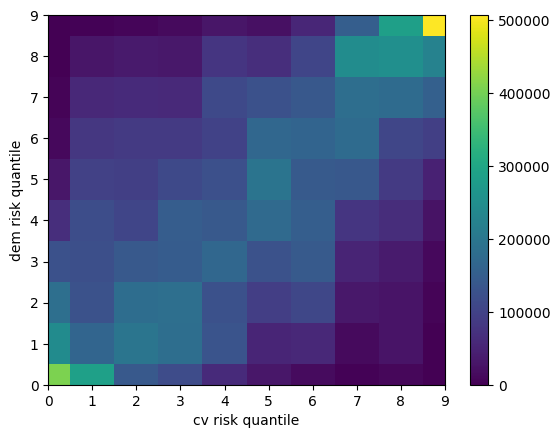

In [32]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, countByRisksArray, shading='nearest')
#ax.set_title('person-years count')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

In [33]:
#for some reason I need to run this in order to make the next graphs interactive
%matplotlib qt

<IPython.core.display.Javascript object>


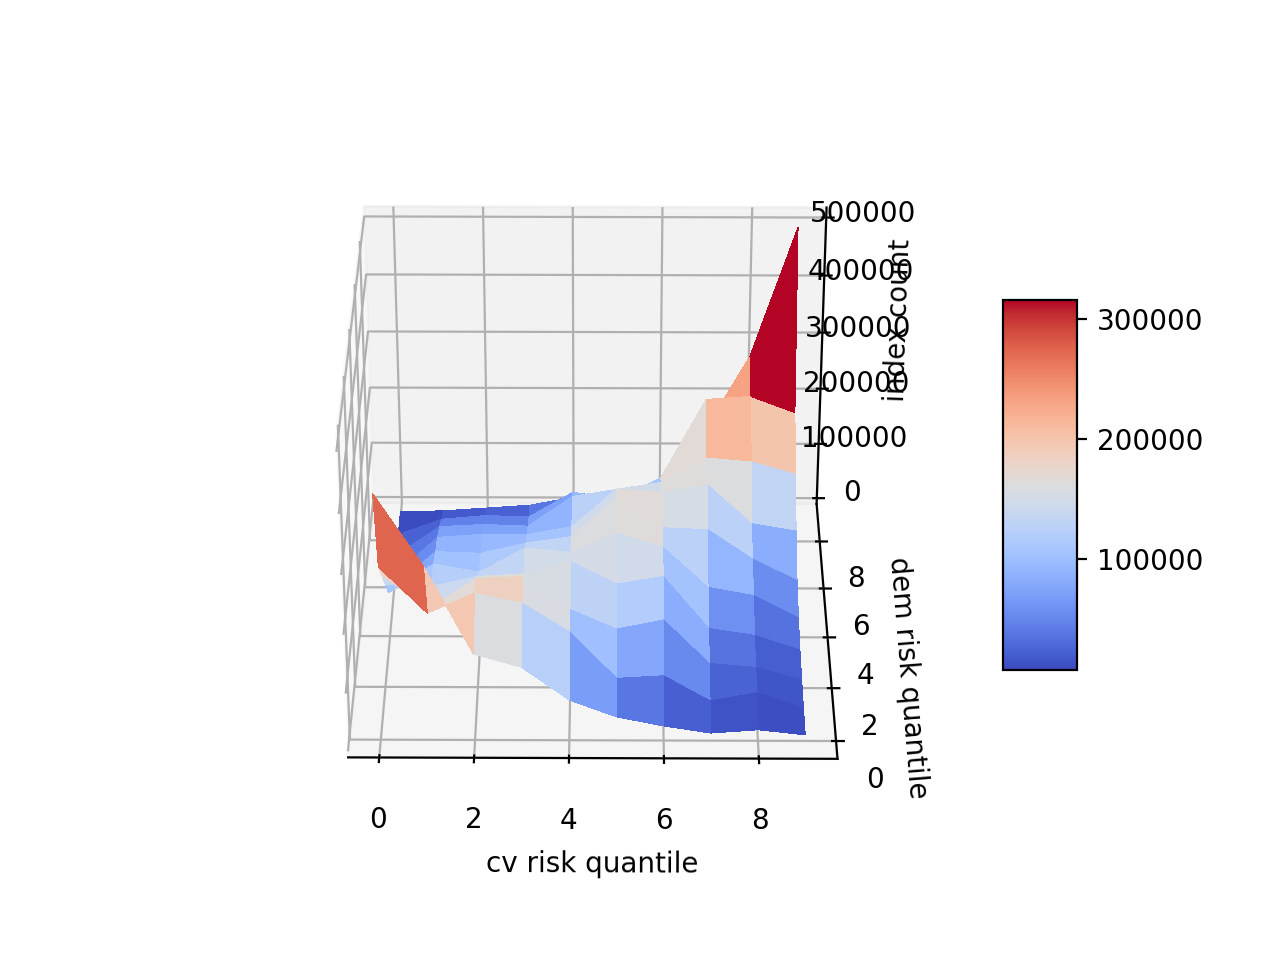

In [54]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, countByRisksArray, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('cv risk quantile')
ax.set_ylabel('dem risk quantile')
ax.set_zlabel('index count')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

<IPython.core.display.Javascript object>


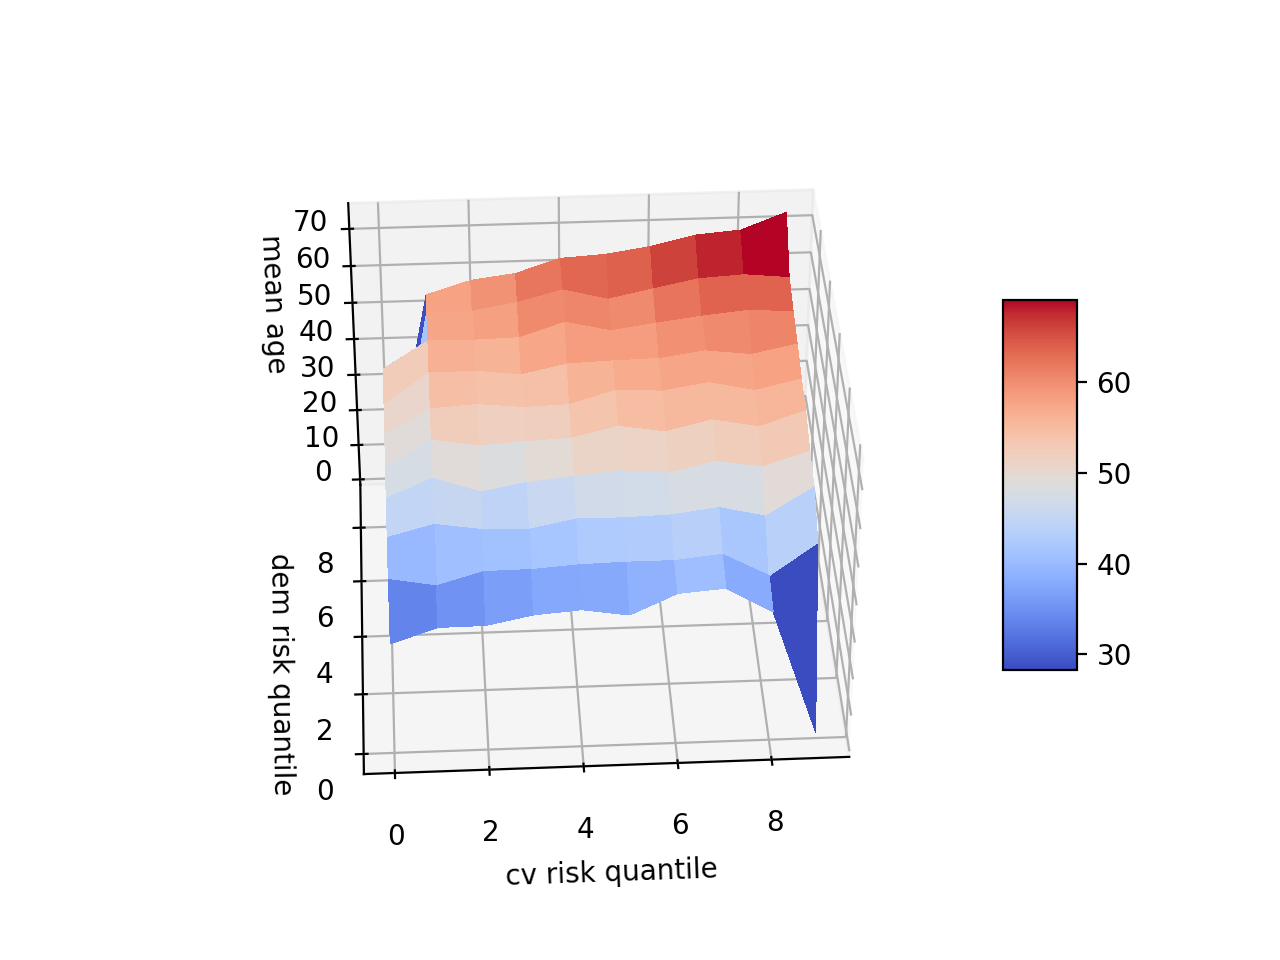

In [55]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, meanAgeByRisksArray, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('cv risk quantile')
ax.set_ylabel('dem risk quantile')
ax.set_zlabel('mean age')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

<IPython.core.display.Javascript object>


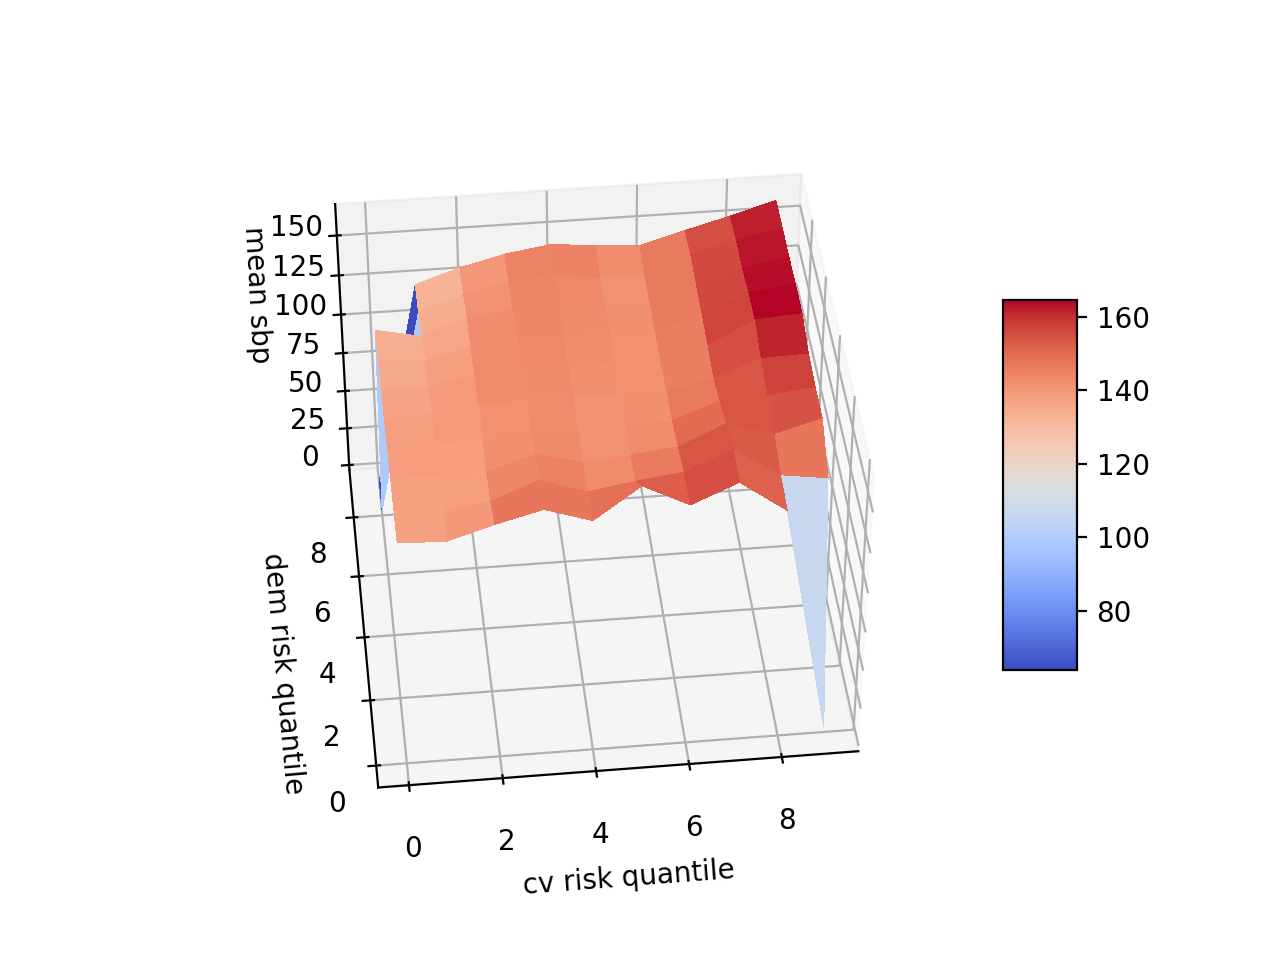

In [56]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, meanSbpByRisksArray, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('cv risk quantile')
ax.set_ylabel('dem risk quantile')
ax.set_zlabel('mean sbp')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

<IPython.core.display.Javascript object>


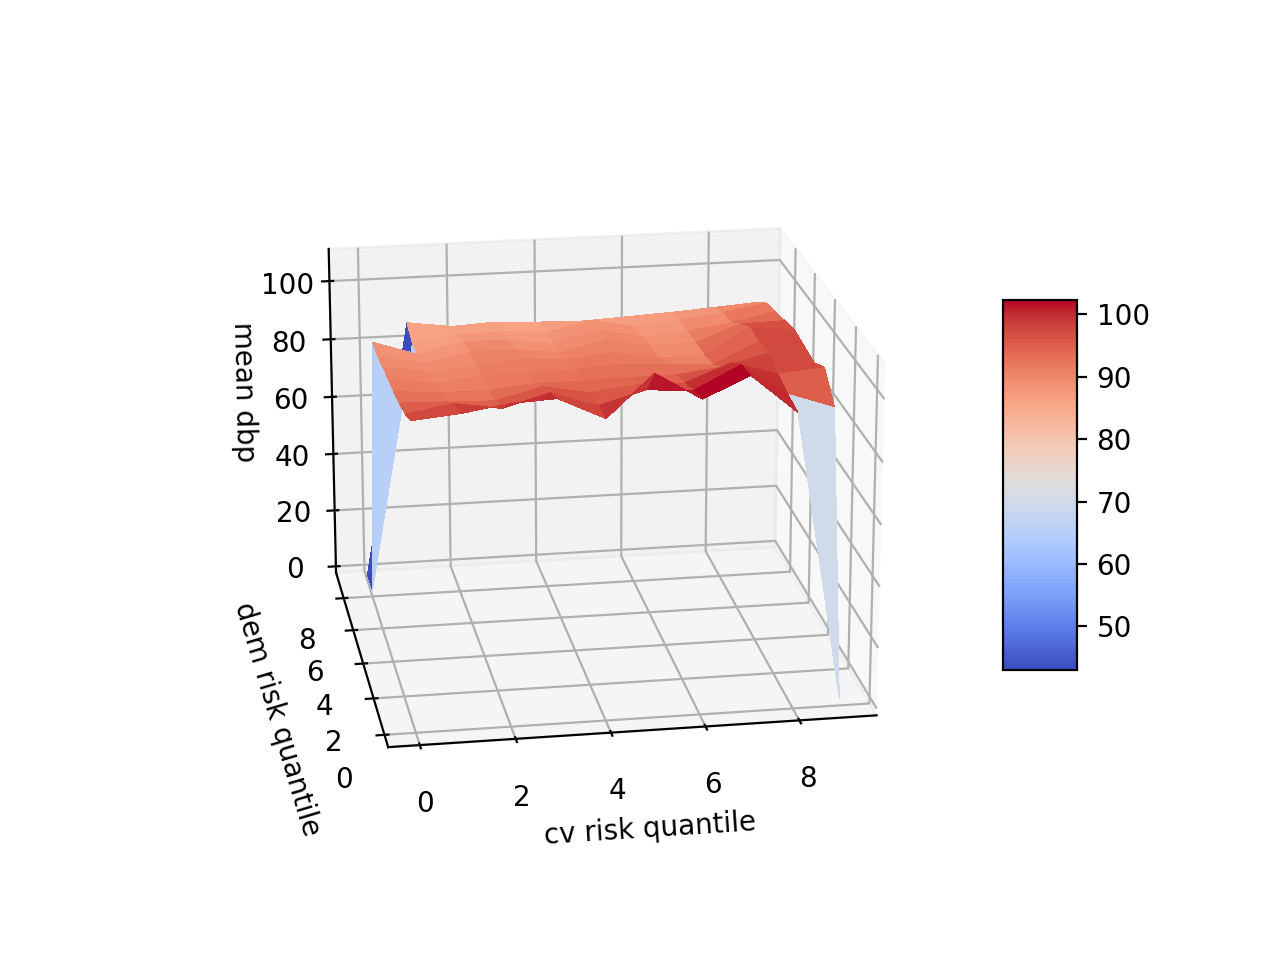

In [57]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, meanDbpByRisksArray, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('cv risk quantile')
ax.set_ylabel('dem risk quantile')
ax.set_zlabel('mean dbp')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

<IPython.core.display.Javascript object>


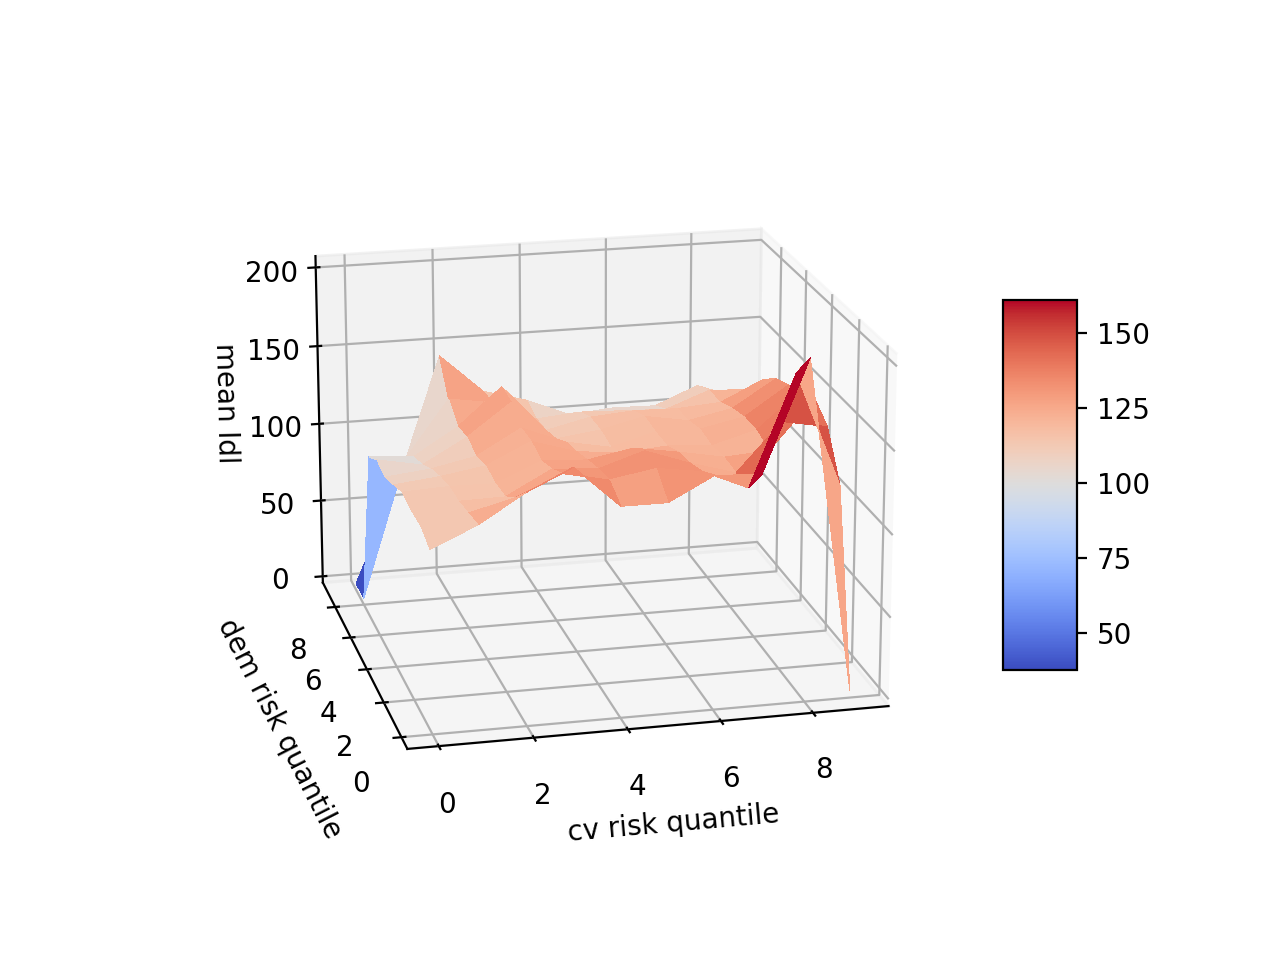

In [58]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, meanLdlByRisksArray, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('cv risk quantile')
ax.set_ylabel('dem risk quantile')
ax.set_zlabel('mean ldl')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

<IPython.core.display.Javascript object>


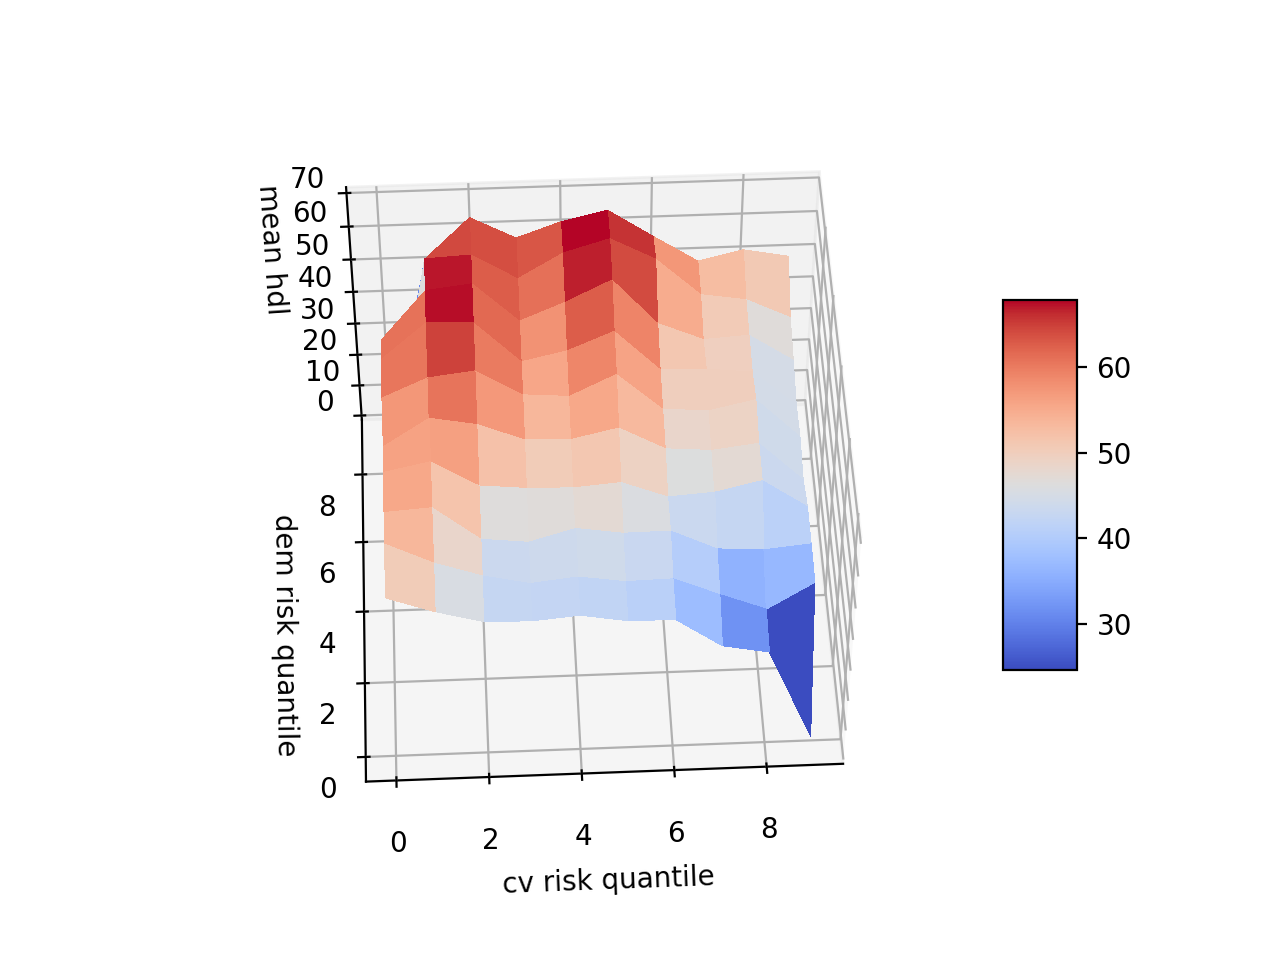

In [59]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, meanHdlByRisksArray, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('cv risk quantile')
ax.set_ylabel('dem risk quantile')
ax.set_zlabel('mean hdl')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

<IPython.core.display.Javascript object>


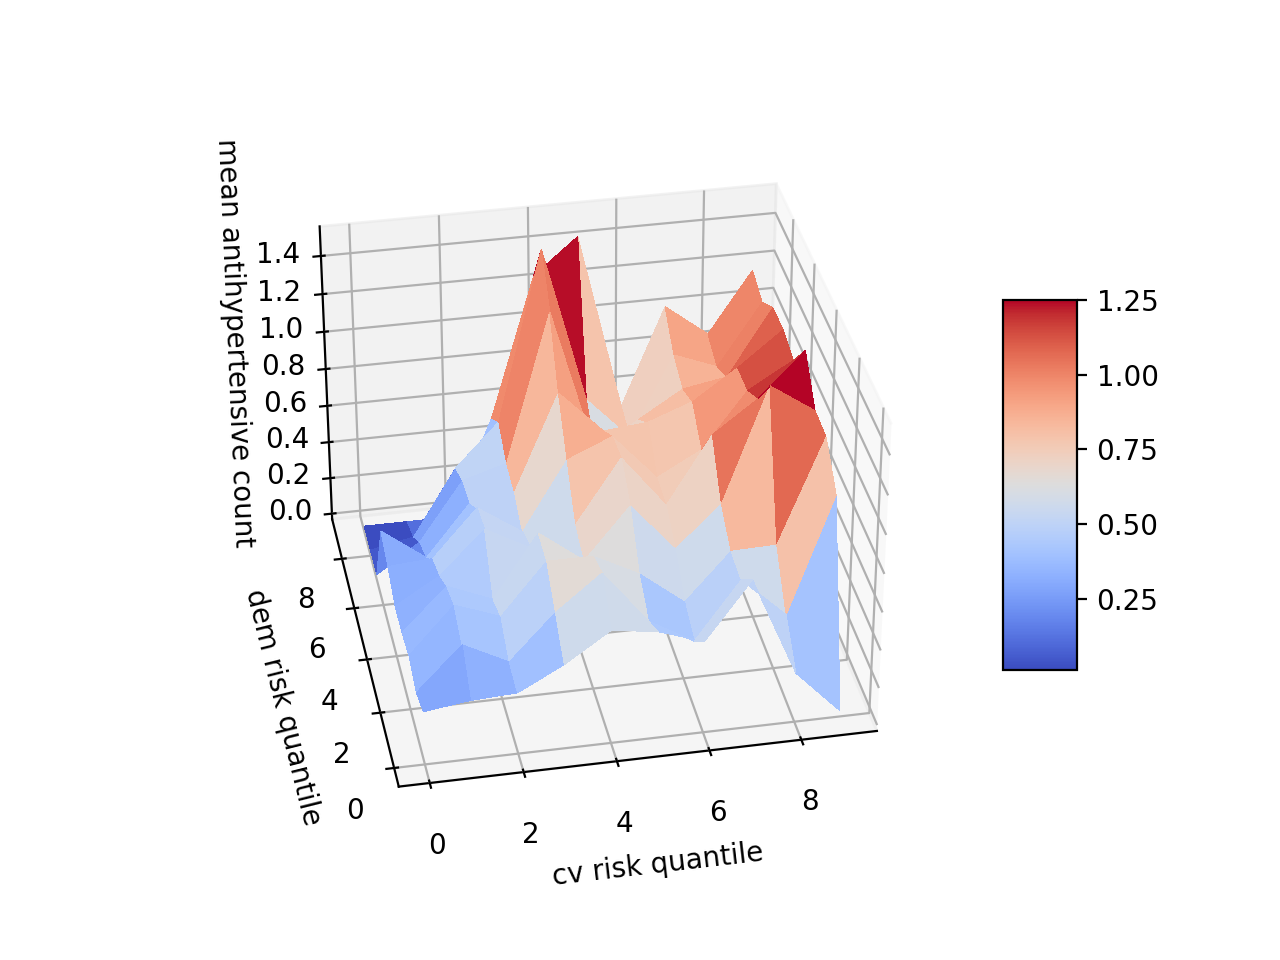

In [60]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, meanAntiHypertensiveCountByRisksArray, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('cv risk quantile')
ax.set_ylabel('dem risk quantile')
ax.set_zlabel('mean antihypertensive count')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

<IPython.core.display.Javascript object>


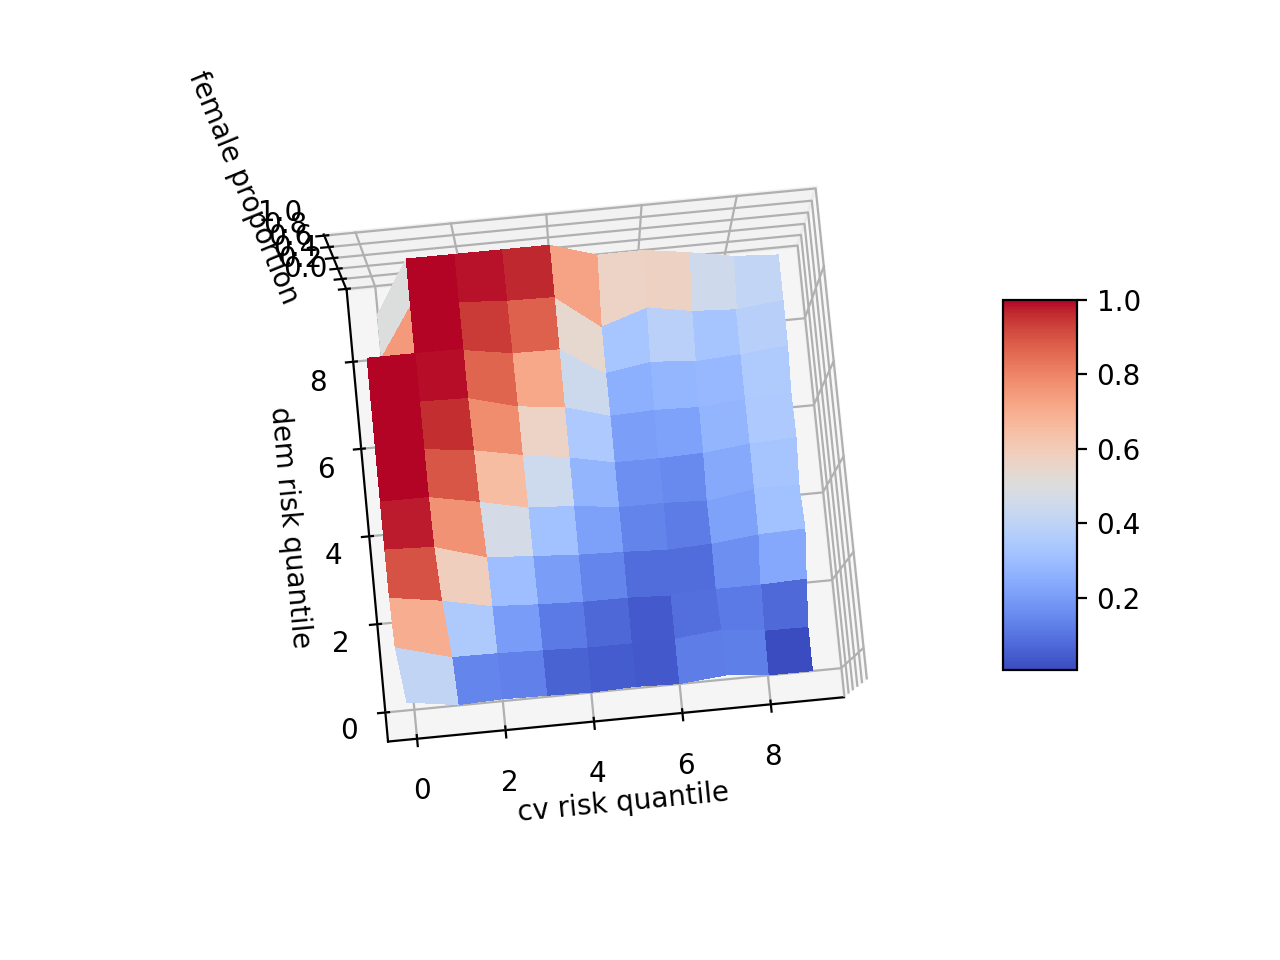

In [64]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, femaleProportionByRisksArray, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('cv risk quantile')
ax.set_ylabel('dem risk quantile')
ax.set_zlabel('female proportion')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

<IPython.core.display.Javascript object>


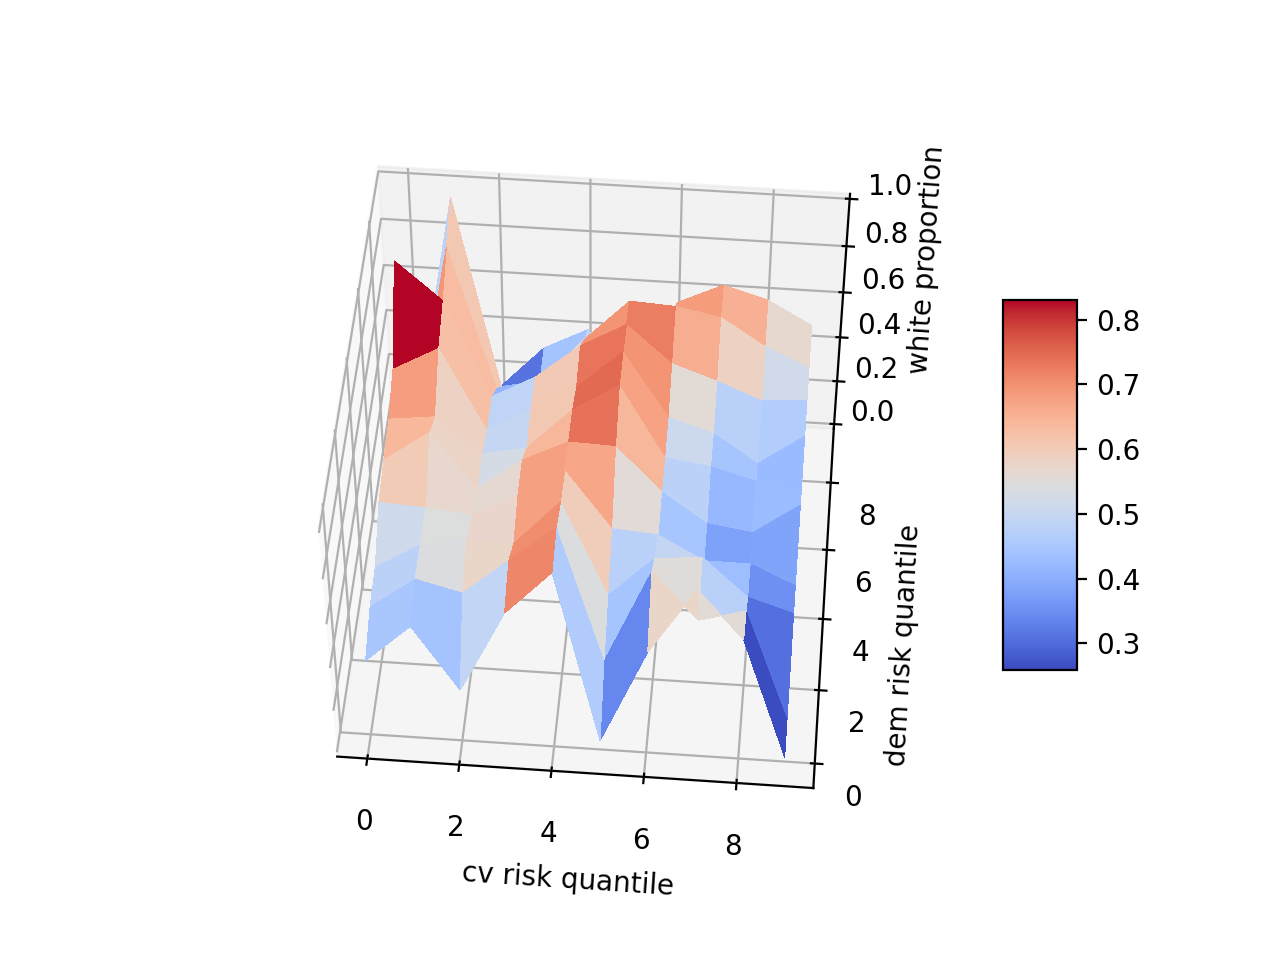

In [73]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, whiteProportionByRisksArray, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('cv risk quantile')
ax.set_ylabel('dem risk quantile')
ax.set_zlabel('white proportion')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [ ]:
#fig, ax = plt.subplots()

#c = ax.pcolormesh(X, Y, countIndexByRisksArray, shading='nearest')
#ax.set_title('NHANES index count')
#plt.xlabel("cv risk quantile")
#plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
#ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
#fig.colorbar(c, ax=ax)

#plt.show()

In [ ]:
#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#surf = ax.plot_surface(X, Y, countIndexByRisksArray, cmap=cm.coolwarm,
#                       linewidth=0, antialiased=False)
#fig.colorbar(surf, shrink=0.5, aspect=5)
#plt.show()

In [35]:
# decide on which quantiles to keep

#based on person-years
included = np.zeros(X.shape)
for i, j in zip(qqcategoriesToInclude["demRisk"],qqcategoriesToInclude["cvRisk"]):
    included[i,j]=1
    
#and based on NHANES indices
#includedIndex = np.zeros(X.shape)
#for i, j in zip(qqcategoriesToInclude["demRisk"],qqcategoriesToIncludeIndex["cvRisk"]):
#    includedIndex[i,j]=1

<IPython.core.display.Javascript object>


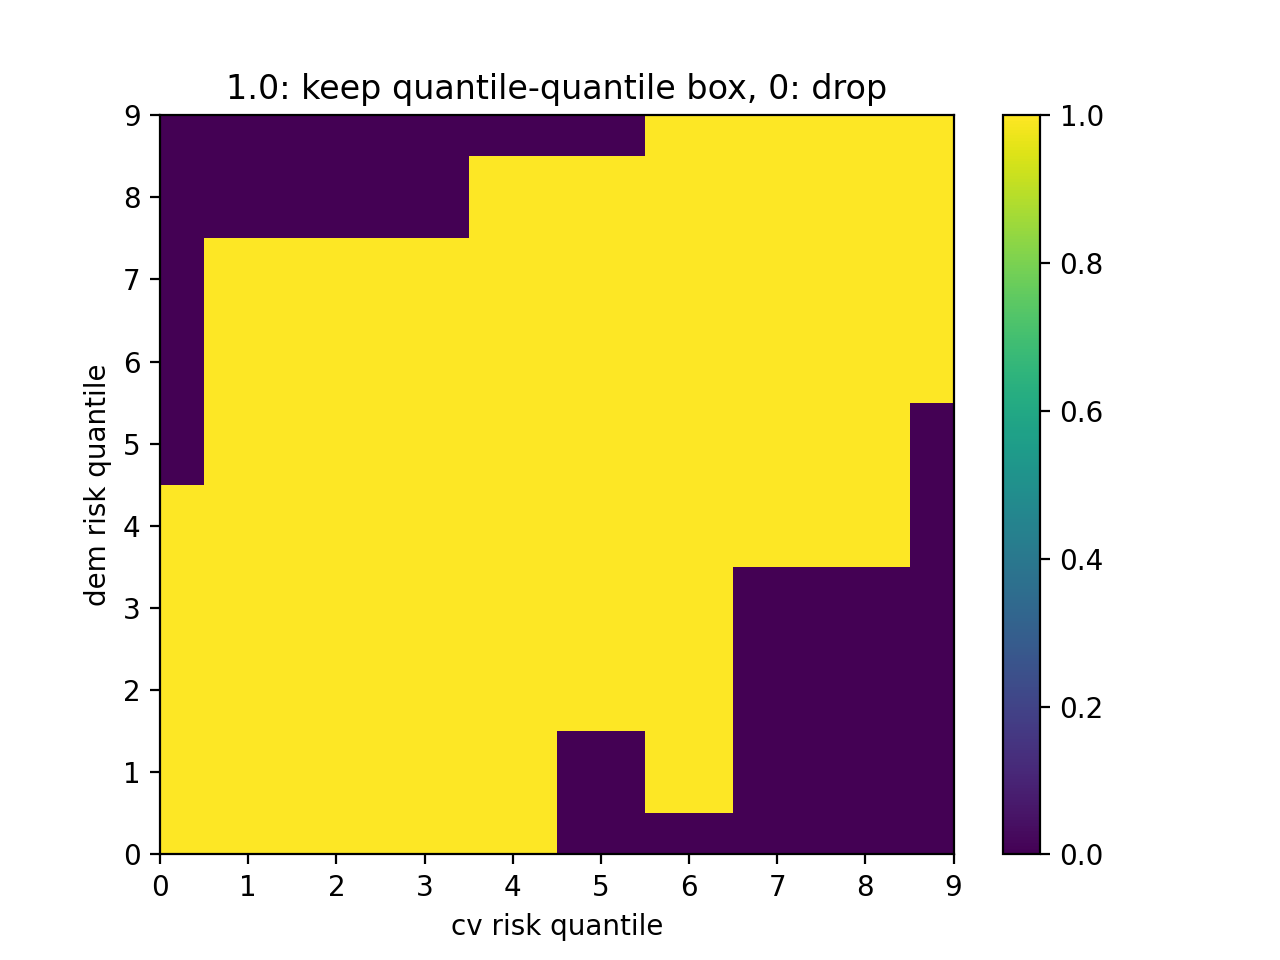

In [36]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, included, shading='nearest')
ax.set_title('1.0: keep quantile-quantile box, 0: drop')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

In [ ]:
#fig, ax = plt.subplots()

#c = ax.pcolormesh(X, Y, includedPersonYears, shading='nearest')
#ax.set_title('1.0: keep quantile-quantile box, 0: drop')
#plt.xlabel("cv risk quantile")
#plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
#ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
#fig.colorbar(c, ax=ax)

#plt.show()

In [ ]:
#fig, ax = plt.subplots()

#c = ax.pcolormesh(X, Y, includedIndex, shading='nearest')
#ax.set_title('1.0: keep quantile-quantile box, 0:drop')
#plt.xlabel("cv risk quantile")
#plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
#ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
#fig.colorbar(c, ax=ax)

#plt.show()

In [ ]:
#now we will export the quantiles we have found
#depending on how we want to proceed we may export all quantiles-quantiles or
#just the ones that meet the person-year cutoff or the NHANES index cutoff
#for now, we will export all quantiles-quantiles

In [37]:
demQuantiles = df.demRisk.quantile(np.arange(0, 1+increment, increment).tolist())
cvQuantiles = df.cvRisk.quantile(np.arange(0, 1+increment, increment).tolist())
quantileDF = pd.DataFrame(index=demQuantiles.index, data={'dementia' : demQuantiles.values, 'cv' : cvQuantiles.values})
quantileDF.T

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
dementia,2.709399e-07,0.000006,0.000012,0.000023,0.000038,0.000060,0.000093,0.000143,0.000241,0.000485,0.013747
cv,6.579283e-05,0.000777,0.001251,0.001996,0.002864,0.003837,0.004778,0.006746,0.010027,0.016021,0.074885


In [ ]:
#demQuantiles = allAgesDF.demRisk.quantile(np.arange(0, 1+increment, increment).tolist())
#cvQuantiles = allAgesDF.cvRisk.quantile(np.arange(0, 1+increment, increment).tolist())
#quantileDF = pd.DataFrame(index=demQuantiles.index, data={'dementia' : demQuantiles.values, 'cv' : cvQuantiles.values})
#quantileDF.T

In [ ]:
#demQuantilesIndex = allIndexAtBaselineDF.demRisk.quantile(np.arange(0, 1+increment, increment).tolist())
#cvQuantilesIndex = allIndexAtBaselineDF.cvRisk.quantile(np.arange(0, 1+increment, increment).tolist())
#quantileIndexDF = pd.DataFrame(index=demQuantilesIndex.index, data={'dementia' : demQuantilesIndex.values, 
#                                                                    'cv' : cvQuantilesIndex.values})
#quantileIndexDF.T

In [38]:
#make the lower end of the quantiles for dementia and cv exactly 0
#
quantileDF.loc[0,"dementia"]=0
quantileDF.loc[0,"cv"]=0
#quantileDF

In [39]:
quantileDF.shape

(11, 2)

In [ ]:
#if you want to verify the quantile calculation above
#allAgesDF.demRisk.describe(), allAgesDF.cvRisk.describe()

In [ ]:
qqcategoriesToIncludePersonYears.reset_index(drop=True,inplace=True)

qqcategoriesToIncludePersonYears.drop(["ageCount"],inplace=True,axis=1)

qqcategoriesToIncludePersonYears["demRiskLowerLimit"] = quantileDF.iloc[
                                                qqcategoriesToIncludePersonYears["demRisk"].to_list()
                                            ]["dementia"].reset_index(drop=True)
qqcategoriesToIncludePersonYears["cvRiskLowerLimit"] = quantileDF.iloc[
                                                qqcategoriesToIncludePersonYears["cvRisk"].to_list()
                                            ]["cv"].reset_index(drop=True)

In [ ]:
#qqcategoriesToIncludePersonYears.transpose().head()

In [ ]:
qqcategoriesToIncludePersonYears.transpose().shape

In [ ]:
#qqcategoriesToIncludePersonYears.head()

In [ ]:
#if you want to export the quantiles to use based on a cutoff
#qqcategoriesToIncludePersonYears.to_csv(dataDir + "/dementiaAndCVQuantilesToInclude.csv")

In [40]:
#if you want to export all quantiles
quantileDF.to_csv(dataDir + "/dementiaAndCVQuantileThresholdsUsingIndex.csv")

In [ ]:
#import pickle
#with open(dataDir + "/demQuantileNumberForQuantile.pickle","wb") as file:
#    pickle.dump(demQuantileNumberForQuantile,file)
#with open(dataDir + "/cvQuantileNumberForQuantile.pickle","wb") as file:
#    pickle.dump(cvQuantileNumberForQuantile,file)

In [ ]:
quantileUsingPersonYearsDF = pd.read_csv(dataDir + "/dementiaAndCVQuantileThresholdsUsingPersonYears.csv",
                                        index_col=0)
quantileUsingIndexDF = pd.read_csv(dataDir + "/dementiaAndCVQuantileThresholdsUsingIndex.csv",index_col=0)

In [ ]:
quantileUsingPersonYearsDF.head(100)

In [ ]:
quantileUsingIndexDF.head(100)

In [ ]:
- quantileUsingIndexDF + quantileUsingPersonYearsDF

In [74]:
df.head()

,sbp,dbp,a1c,hdl,ldl,trig,totChol,bmi,anyPhysicalActivity,afib,alcoholPerWeek,creatinine,antiHypertensiveCount,statin,waist,alive,gcp,bpMedsAdded,age,baseAge,gender,raceEthnicity,black,current_diabetes,gfr,education,current_bp_treatment,smokingStatus,current_smoker,gcpRandomEffect,miPriorToSim,strokePriorToSim,mi,stroke,ageAtFirstStroke,ageAtFirstMI,ageAtFirstDementia,miInSim,strokeInSim,dementia,baseGcp,gcpSlope,totalYearsInSim,totalBPMedsAdded,totalQalys,dfIndex,cvRisk,demRisk,demRiskQuantile,cvRiskQuantile,meanDemRiskForQuantile,meanCVRiskForQuantile,cvQuantileNum,demQuantileNum,genderMale0Female1
0,130.605653,88.204219,5.932394,36.265800,118.534205,104.157289,175.670370,51.363082,True,False,1,1.007539,0,False,153.610375,True,73.650640,0.0,44.0,43.0,1,3,False,False,90.307043,3,False,1,False,10.375926,0,0,False,False,NaN,NaN,NaN,False,False,False,62.892505,0.0,1,0.0,0,56858,0.001825,0.000012,"(5.84e-06, 1.24e-05]","(0.00125, 0.002]",0.000009,0.001637,2,1,0
0,176.678832,110.421495,5.618705,28.621230,86.726580,320.140359,179.199165,38.871197,False,False,0,8.406651,0,False,117.407256,True,55.682962,0.0,46.0,45.0,1,3,False,False,6.850062,4,False,0,False,-3.302496,0,0,False,False,NaN,NaN,NaN,False,False,False,51.660441,0.0,1,0.0,0,58151,0.006962,0.000030,"(2.29e-05, 3.85e-05]","(0.00675, 0.01]",0.000030,0.008545,7,3,0
0,163.388095,108.527086,5.836499,85.400562,138.612910,102.403029,244.552004,27.367248,True,False,2,0.539377,0,False,94.201696,True,70.069229,0.0,39.0,38.0,2,1,False,False,119.296512,3,False,2,True,3.783664,0,0,False,False,NaN,NaN,NaN,False,False,False,71.963875,0.0,1,0.0,0,58753,0.001412,0.000004,"(-0.000999729, 5.84e-06]","(0.00125, 0.002]",0.000003,0.001637,2,0,1
0,154.526809,89.002871,5.220207,84.325395,104.500071,109.510102,204.654213,28.854096,False,False,1,0.814993,3,True,92.895847,True,43.484362,0.0,63.0,62.0,2,3,False,False,76.966882,4,True,1,False,-6.519288,0,0,False,False,NaN,NaN,NaN,False,False,False,49.013380,0.0,1,0.0,0,58877,0.003147,0.000227,"(0.000143, 0.000241]","(0.00286, 0.00384]",0.000186,0.003343,4,7,1
0,151.332602,87.770355,5.848650,40.199818,78.651991,149.223795,148.620704,28.440482,True,False,1,1.001582,1,True,104.859877,True,59.502817,0.0,69.0,68.0,1,3,False,False,76.307366,4,True,1,False,-1.619649,0,0,False,False,NaN,NaN,-1.0,False,False,False,43.228567,0.0,1,0.0,0,58708,0.010638,0.000590,"(0.000485, 0.0137]","(0.01, 0.016]",0.001434,0.012945,8,9,0


In [75]:
df[df["cvQuantileNum"]==1 and df["demQuantileNum"]==9].head()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().